In [1]:
import h5py
import json
import numpy as np
import torch as pt
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob

from structures_store import h5_load_structure

colors = ['#bf4e30', '#0d3b66', '#0e9595', '#c2c1c2', '#dbad6a']

In [2]:
uniprots = pd.read_csv("datasets/selected_alphafold_models.csv").query("selected > 0.5")['uniprot'].values

data = {}
with h5py.File("datasets/aggregated_structures_data.h5", 'r') as hf:
    #for uniprot in tqdm(hf.keys()):
    for uniprot in tqdm(uniprots):
        data[uniprot] = h5_load_structure(hf[uniprot])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7464/7464 [00:20<00:00, 360.18it/s]


In [3]:
# subcellular location
locs_dict = json.load(open("datasets/subcellularlocation.json", 'r'))

# go terms
goterms = json.load(open("datasets/goterms.json", 'r'))

# clustered interfaces
interfaces = json.load(open("datasets/clustered_interfaces.json", 'r'))

In [4]:
def aggregate_interfaces_tags(data, tag_dict, interfaces):
    mp_tags = [{} for i in range(5)]
    for uniprot in tqdm(data):
        if (uniprot in tag_dict) and (uniprot in interfaces):
            entry = data[uniprot]
            int_l = interfaces[uniprot]
            tags = np.unique(tag_dict[uniprot])
            #tags = tag_dict[uniprot]
            
            for i in range(5):
                if len(int_l[i]) > 0:
                    # pick only best interface
                    mp = np.max([np.mean(entry[f'p{i}'][ids_int]) for ids_int in int_l[i]])                    
                    for tag in tags:
                        if tag in mp_tags[i]:
                            mp_tags[i][tag].append(mp)
                        else:
                            mp_tags[i][tag] = [mp]
                            
    tag_counts = {}
    for uniprot in tqdm(data):
        if (uniprot in tag_dict) and (uniprot in interfaces):
            for tag in np.unique(tag_dict[uniprot]):
            #for tag in tag_dict[uniprot]:
                if tag in tag_counts:
                    tag_counts[tag] += 1
                else:
                    tag_counts[tag] = 1
    
    return mp_tags, tag_counts

## Subcellularlocation

In [5]:
# aggregate mean interface predictions by subcellularlocation
mp_locs, loc_counts = aggregate_interfaces_tags(data, locs_dict, interfaces)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7464/7464 [00:00<00:00, 149570.42it/s]


In [6]:
sel_tags = [
    'Cytoplasm',
    'Peroxisome',
    'Nucleus',
    'Mitochondrion',
    'Lysosome',
    'Golgi apparatus',
    'Extracellular space',
    'Endoplasmic reticulum',
    'Cell membrane',
]
#sel_tags = list(p_locs)

In [7]:
# parameters
p_thr = 0.8

H = []
for i in range(5):
    H.append([])
    for tag in sel_tags:
        p = np.array(mp_locs[i][tag])

        c = np.sum(p > p_thr, axis=0)
        H[i].append(c)
    
H = np.array(H).T
H = H / np.array([loc_counts[tag] for tag in sel_tags]).reshape(-1,1)
#H = H / np.sum(H,axis=1).reshape(-1,1)
#H = H / np.sum(H,axis=0)

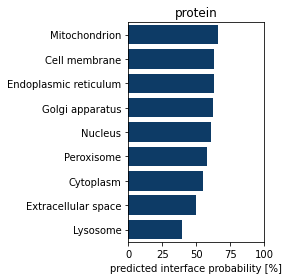

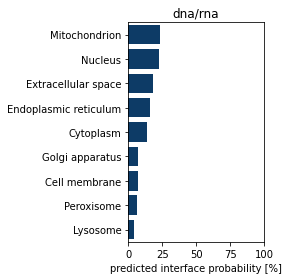

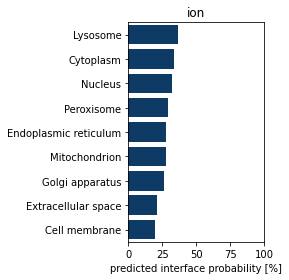

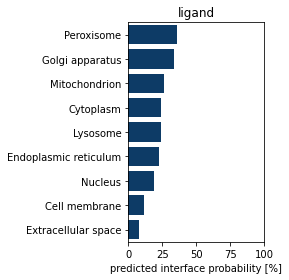

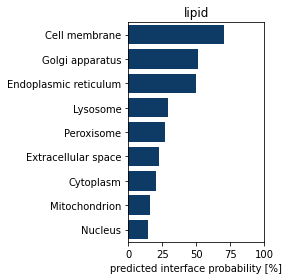

In [8]:
labels = ["protein", "dna/rna", "ion", "ligand", "lipid"]
for i in range(5):
    t = np.arange(H.shape[0])
    x = np.array(sel_tags)
    y = H[:,i]
    ids = np.argsort(y)

    # plot
    plt.figure(figsize=(4,4))
    plt.barh(t, y[ids]*1e2, color=colors[1])
    plt.yticks(t, x[ids])
    plt.title(labels[i])
    plt.xlim(0.0, 1.0*1e2)
    plt.ylim(-0.5, len(t)-0.5)
    plt.xlabel("predicted interface probability [%]")
    plt.tight_layout()
    plt.savefig("results/locations_p{}.png".format(i), dpi=300)
    plt.savefig("results/locations_p{}.svg".format(i))
    plt.show()

## GO terms functions

In [9]:
# aggregate mean interface predictions by function GO term
gt_fct = {uniprot:goterms[uniprot]['F'] for uniprot in goterms if 'F' in goterms[uniprot]}
mp_gts, gt_counts = aggregate_interfaces_tags(data, gt_fct, interfaces)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7464/7464 [00:00<00:00, 124800.82it/s]


In [10]:
# parameters
p_thr = 0.8
min_sampling = 200

# all tags
sel_tags = np.unique(np.concatenate([list(mp_gts[i]) for i in range(5)]))

H = []
for i in range(5):
    H.append([])
    for tag in sel_tags:
        if tag in mp_gts[i]:
            p = np.array(mp_gts[i][tag])
            c = np.sum(p > p_thr, axis=0)
        else:
            c = 0
        H[i].append(c)
    
H = np.array(H).T
m = (np.sum(H,axis=1) > min_sampling)
H = H[m]
sel_tags = sel_tags[m]
H = H / np.array([gt_counts[tag] for tag in sel_tags]).reshape(-1,1)
#H = H / np.sum(H, axis=1).reshape(-1,1)

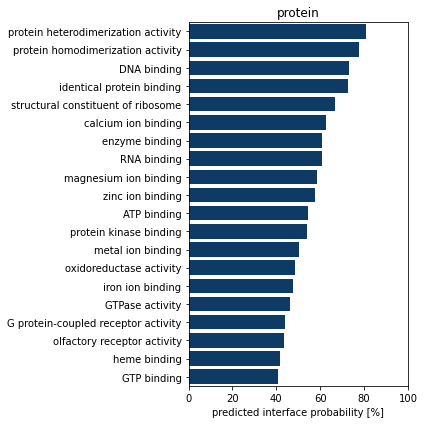

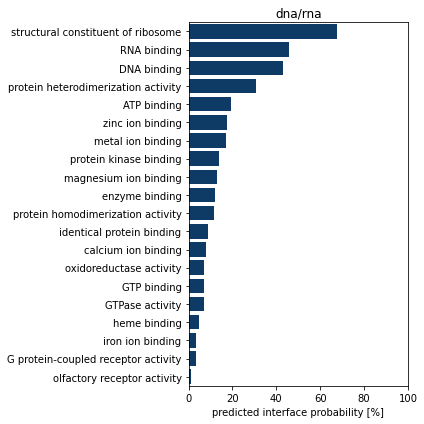

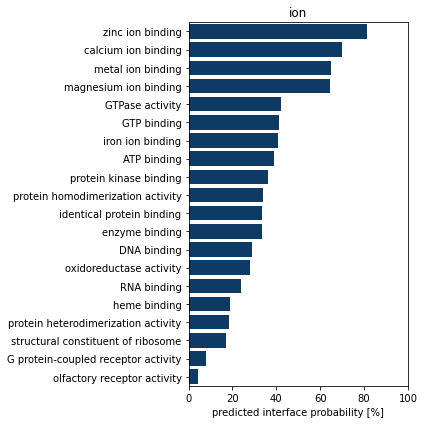

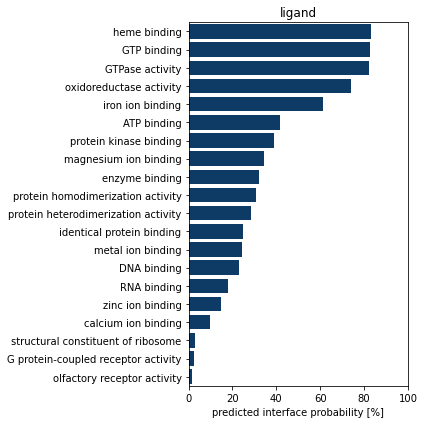

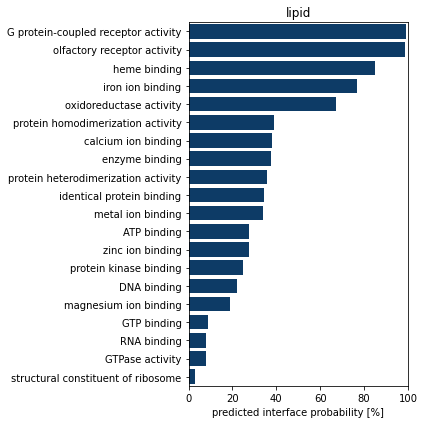

In [11]:
# parameters
N = 30

labels = ["protein", "dna/rna", "ion", "ligand", "lipid"]
for i in range(5):
    x = np.array(sel_tags)
    y = H[:,i]
    ids = np.argsort(y)[::-1][:N][::-1]
    t = np.arange(H.shape[0])[:N]

    # plot
    plt.figure(figsize=(6,6))
    plt.barh(t, y[ids]*1e2, color=colors[1])
    plt.yticks(t, x[ids])
    plt.title(labels[i])
    plt.xlim(0.0, 100.0)
    plt.ylim(-0.5, len(t)-0.5)
    plt.xlabel("predicted interface probability [%]")
    plt.tight_layout()
    plt.savefig("results/goterms_F_p{}.png".format(i), dpi=300)
    plt.savefig("results/goterms_F_p{}.svg".format(i))
    plt.show()

## GO terms processes

In [12]:
# aggregate mean interface predictions by function GO term
gt_fct = {uniprot:goterms[uniprot]['P'] for uniprot in goterms if 'P' in goterms[uniprot]}
mp_gts, gt_counts = aggregate_interfaces_tags(data, gt_fct, interfaces)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7464/7464 [00:00<00:00, 105853.16it/s]


In [13]:
# parameters
p_thr = 0.8
min_sampling = 200

# all tags
sel_tags = np.unique(np.concatenate([list(mp_gts[i]) for i in range(5)]))

H = []
for i in range(5):
    H.append([])
    for tag in sel_tags:
        if tag in mp_gts[i]:
            p = np.array(mp_gts[i][tag])
            c = np.sum(p > p_thr, axis=0)
        else:
            c = 0
        H[i].append(c)
    
H = np.array(H).T
m = (np.sum(H,axis=1) > min_sampling)
H = H[m]
sel_tags = sel_tags[m]
H = H / np.array([gt_counts[tag] for tag in sel_tags]).reshape(-1,1)

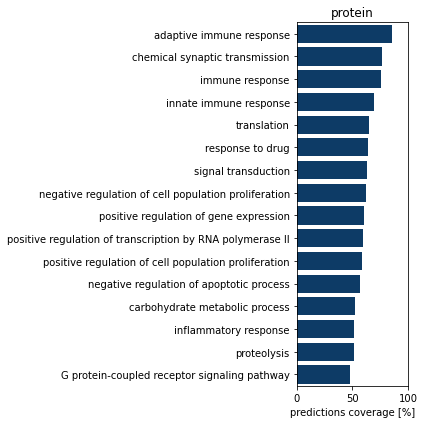

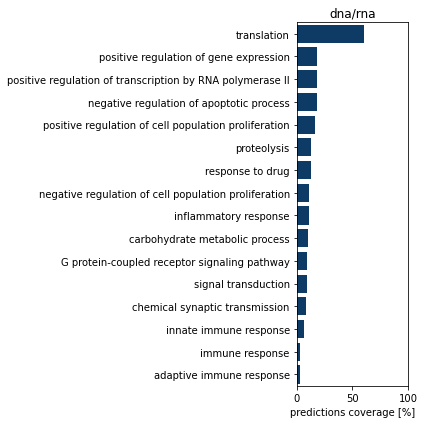

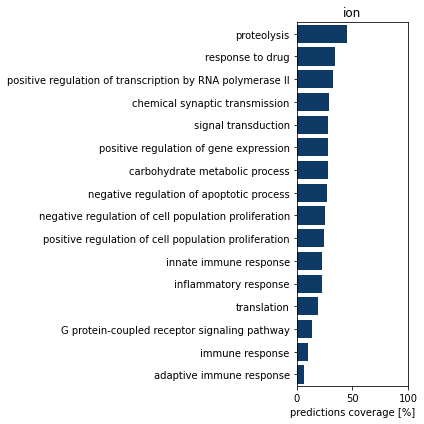

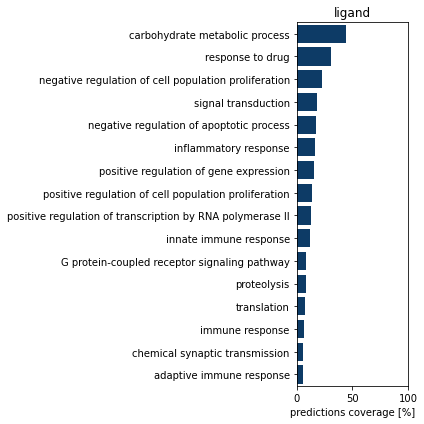

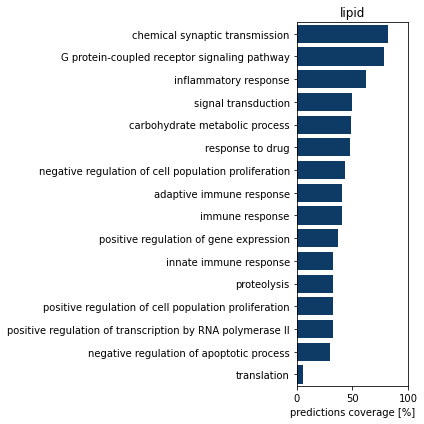

In [14]:
# parameters
N = 30

labels = ["protein", "dna/rna", "ion", "ligand", "lipid"]
for i in range(5):
    x = np.array(sel_tags)
    y = H[:,i]
    ids = np.argsort(y)[::-1][:N][::-1]
    t = np.arange(H.shape[0])[:N]

    # plot
    plt.figure(figsize=(6,6))
    plt.barh(t, y[ids]*1e2, color=colors[1])
    plt.yticks(t, x[ids])
    plt.title(labels[i])
    plt.xlim(0.0, 100.0)
    plt.ylim(-0.5, len(t)-0.5)
    plt.xlabel("predicted interface probability [%]")
    plt.xlabel("predictions coverage [%]")
    plt.tight_layout()
    plt.savefig("results/goterms_P_p{}.png".format(i), dpi=300)
    plt.savefig("results/goterms_P_p{}.svg".format(i))
    plt.show()